In [4]:
import sys, os
import time, pickle
from ete3 import NCBITaxa
sys.path.append("/Users/chilpert/Dev/pyproteinsExt/src")
sys.path.append("/Users/chilpert/Dev/pyproteins/src")
import pyproteinsExt.topology as topology
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import copy
from collections import OrderedDict

In [5]:
def save(data, tag=None):
    saveDir="/Volumes/arwen/mobi/group/NOX_clean/pickle_saved"
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fTag = "NOX_annotation_" + tag + "_" if tag else "NOX_annotation_"
    fSerialDump = fTag + timestr + ".pickle"
    with open(saveDir + '/' + fSerialDump, 'wb') as f:
        pickle.dump(data, f)
    print('data structure saved to', saveDir + '/' + fSerialDump)

def load(fileName):
    saveDir="/Volumes/arwen/mobi/group/NOX_clean/pickle_saved"
    d = pickle.load( open(saveDir + "/" + fileName, "rb" ) )
    print("restore a annotated container of ", len(d), "elements")
    return d

# Annotation

## Annotate domains

#### Launch hmmscan against full Pfam

```console
ROOT_DIR=/mobi/group/NOX_clean
SCRIPT_DIR=/mobi/group/NOX_clean/nox-analysis/scripts

mkdir -p $ROOT_DIR/results/Domains_annotation
cd $ROOT_DIR/results/Domains_annotation

sbatch $SCRIPT_DIR/runHMMSCAN.sbatch /mobi/group/databases/hmmr/Pfam-A_32.hmm $ROOT_DIR/NOX_fasta/predicted_NOX_proteins_validated.mfasta $ROOT_DIR/results/Domains_annotation/predicted_NOX_proteins_hmmscan.out
```

#### Replace hmmr annotations in data container

In [32]:
data=load("NOX_annotation_validatedProteins_20190808-155906.pickle")

restore a annotated container of  769 elements


In [33]:
data.complete_hmmr("/Volumes/arwen/mobi/group/NOX_clean/results/Domains_annotation/predicted_NOX_proteins_hmmscan.out")

In [34]:
data.create_domain_entries()

### Domains with evalue <= 1e-3

#### Filter domains with evalue > 1e-3

In [35]:
def filterEvalue_hits(hit,**kwargs):
    threshold=kwargs["threshold"]
    if float(hit.hit.iEvalue)<=threshold:
        return True
    return False

In [36]:
data_evalue3=data.filter_hit(filterEvalue_hits,threshold=1e-3)

#### Discard overlapped domains

When we have a group of overlapped domains, just conserve the domain with best evalue. 

* List overlapped hits for each hit, with a threshold of 10 amino acids (if the overlap length is less than 10, then it's not considered as overlap)

In [37]:
data_evalue3.compute_overlapped_domains(10)

In [38]:
def best_evalue(list_hit):
        evalues=[float(h.hit.iEvalue) for h in list_hit]
        best_evalue=min(evalues)
        conserve_hit=[h for h in list_hit if float(h.hit.iEvalue)==best_evalue]
        if len(conserve_hit)>1: 
            raise Exception("best_evalue conserve_hit>1. Check.")
        return conserve_hit[0] 

In [39]:
def filter_overlapped_domains(hit):
    core_domains=["ferric_reduct_prokaryotes","nad_binding_prokaryotes","fad_binding_prokaryotes"]
    if hit.domain in core_domains: 
        return True
    if not hit.overlapped_hits: 
        return True
    overlap_hits_core=[h for h in hit.overlapped_hits if h.domain in core_domains]
    if not overlap_hits_core:
        conserve_hit=best_evalue([hit]+hit.overlapped_hits)
        if conserve_hit==hit:
            return True
    return False

* Conserve 1 domain for each overlapped group

How it works ? Core hits are conserved. Each hit have associated list of overlapped hit. If hit doesn't overlap with core hits and has the best evalue among all its overlapped hits, hit is conserved. 

In [40]:
data_overlap_domains=data_evalue3.filter_hit(filter_overlapped_domains)

* Domains graphs

In [41]:
data_overlap_domains.create_domain_entries()

In [42]:
def graph_biggest_domains(data,output_pdf,graph_title,nb_core):
    all_domains=set([h.domain for e in data for h in e.hmmr])
    height=[len(d.proteins) for d in data.domain_entries.values()]
    bars=tuple(data.domain_entries.keys())
    height=height[::-1]
    bars=bars[::-1]
    plt.figure(0)
    plt.barh(bars,height)
    plt.title(graph_title)
    plt.xlabel("Number of proteins with the domain")
    plt.ylabel("Domains")
    plt.tight_layout()       
    plt.savefig(output_pdf,format="pdf")
    
    no_core_height=height[:-nb_core]
    no_core_bars=bars[:-nb_core]
    #no_core_domain_ypos=np.arange(len(no_core_domain_bars))
    plt.figure(1)
    plt.barh(no_core_bars,no_core_height)
    plt.title(graph_title+", no core domains")
    plt.xlabel("Number of proteins with the domain")
    plt.ylabel("Domains")
    plt.tight_layout()
    pdf=output_pdf.split(".")[0]+"_no_core.pdf"
    plt.savefig(pdf,format="pdf")
    
def graph_distrib_nb_domains(data_graph,graph_title,output_pdf): 
    dic_nb_domain={}
    for e in data_graph : 
        nb_domain=len([h for h in e.hmmr])
        if nb_domain not in dic_nb_domain : 
            dic_nb_domain[nb_domain]=0
        dic_nb_domain[nb_domain]+=1 
    max_domains=max([d for d in dic_nb_domain])
    x=list(dic_nb_domain.keys())
    y=list(dic_nb_domain.values())
    plt.bar(x,y)
    plt.title(graph_title)
    plt.xlim(0,max_domains+1)
    plt.xlabel("Number of domains")
    plt.ylabel("Number of proteins")
    plt.savefig(output_pdf,format="pdf")    

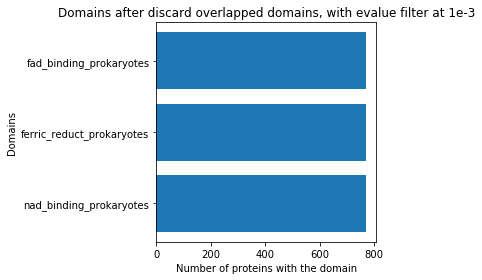

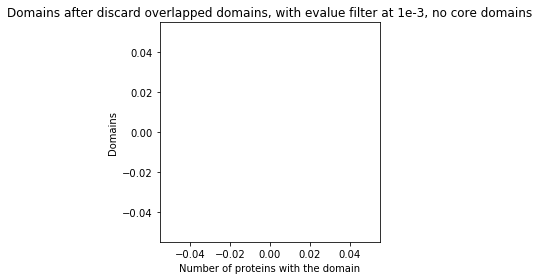

In [43]:
graph_biggest_domains(data_overlap_domains,"/Users/chilpert/Results/NOX_visu_clean/NOX_domains_proteins_1e-3_no_overlap.pdf","Domains after discard overlapped domains, with evalue filter at 1e-3",3)

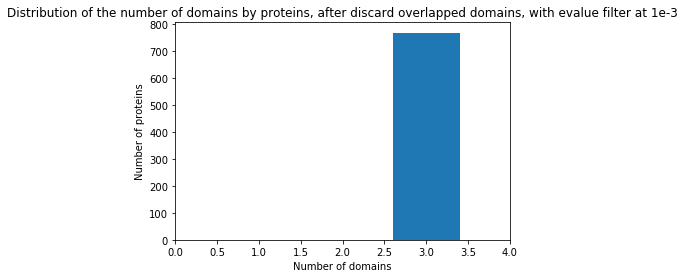

In [44]:
graph_distrib_nb_domains(data_overlap_domains,"Distribution of the number of domains by proteins, after discard overlapped domains, with evalue filter at 1e-3","/Users/chilpert/Results/NOX_visu_clean/NOX_distrib_nb_domains_1e-3_no_overlap.pdf")

#### Create and complete ete3 tree

In [19]:
data_overlap_domains.create_ete3_tree()

#### Compute upper node for each domain

In [54]:
core_domains={"ferric_reduct_prokaryotes","nad_binding_prokaryotes","fad_binding_prokaryotes"}

In [55]:
data_overlap_domains.compute_upper_node_and_distance()

In [57]:
sys.setrecursionlimit(10000)
save(data_overlap_domains,"withDomainEntries")
sys.setrecursionlimit(3000)

data structure saved to /Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_withDomainEntries_20190808-164140.pickle


#### Tsv outputs

In [24]:
data_overlap_domains = load("NOX_annotation_withDomainEntries_20190808-164140.pickle")

restore a annotated container of  769 elements


In [25]:
domains_output="/Volumes/arwen/mobi/group/NOX_clean/results/Domains_annotation/NOX_domains_stats.tsv"
proteins_output="/Volumes/arwen/mobi/group/NOX_clean/results/Domains_annotation/NOX_proteins_stats.tsv"
by_species_output="/Volumes/arwen/mobi/group/NOX_clean/results/Domains_annotation/NOX_by_species_stats.tsv"
by_genus_output="/Volumes/arwen/mobi/group/NOX_clean/results/Domains_annotation/NOX_by_genus_stats.tsv"

In [26]:
def write_domains_output(data,domains_output): 
    o=open(domains_output,"w")
    o2=open(domains_output.split(".")[0]+"_detailed.tsv","w")
    o.write("#Domain(s)\tNumber of associated proteins\tUpper node\tMean distance\n")
    o2.write("#Domain(s)\tNumber of associated proteins\tUpper node\tMean distance\tList of associated proteins\tList of taxids\n")
    for d in data.domain_entries.values():
        o.write("%s\t%d\t%s\t%f\n" % (d.name,len(d.proteins),d.upper_node.name+"."+d.upper_node.sci_name,d.mean_distance))
        o2.write("%s\t%d\t%s\t%f\t%s\t%s\n" % (d.name,len(d.proteins),d.upper_node.name+"."+d.upper_node.sci_name,d.mean_distance,";".join([p.split('|')[1] for p in d.proteins]),";".join([t.taxid for d in data.domain_entries.values() for t in d.taxo])))
    o.close()
    o2.close()

    #c=0
    #for d in set_domain_groups:
    #    o.write("%s\t%d\t%s\t%s\t%s\t%s\t%.5f\t%.5f\t%.5f\n" % (",".join(d.domains),len(d.proteins),",".join(d.proteins),d.upper_node.name,d.upper_node.sci_name,d.upper_node.rank,d.percent_taxo,d.mean_dist,d.max_dist))
    #o.close()
    
def write_proteins_output(data,proteins_output):
    o=open(proteins_output,"w")
    o.write("#Protein\tLength\tTaxid\tTaxname\tNumber of domains\tDomains\n")
    for e in data: 
        o.write("%s\t%d\t%s\t%s\t%d\t%s\n" % (e.prot,len(e.fasta.seq),e.taxo.taxid,e.taxo.taxname,len(set([h.domain for h in e.hmmr])),";".join(set([h.domain for h in e.hmmr]))))
    o.close()    
    
def write_by_tax_level_output(data,tax_level,output): 
    o=open(output,"w")
    o.write("#Taxo level\tTaxo name\tNumber of proteins\tNumber of domains\tProteins\tDomains\n")
    for n in data.ete3_tree.traverse(): 
        if n.rank == tax_level: 
            o.write("%s\t%s\t%d\t%d\t%s\t%s\n" % (tax_level,n.sci_name,len(n.proteins),len(n.domains),";".join([p.split('|')[1] for p in n.proteins]),";".join(n.domains)))
    o.close()

In [27]:
def get_dic_taxlevel(data,tax_level):
    dic={}
    for n in data.ete3_tree.traverse():
        if n.rank == tax_level: 
            dic[n.sci_name]={'proteins':n.proteins,'domains':n.domains}
    return dic        

In [28]:
write_domains_output(data_overlap_domains,domains_output)
write_proteins_output(data_overlap_domains,proteins_output)
write_by_tax_level_output(data_overlap_domains,"species",by_species_output)
write_by_tax_level_output(data_overlap_domains,"genus",by_genus_output)

#### Most abondant taxonomy for several ranks

In [29]:
def graph_most_abondant_rank(data,rank,topX,pdf_output): 
    rank_dic=get_dic_taxlevel(data,rank)
    ordered_rank_dic=OrderedDict(sorted(rank_dic.items(),key=lambda kv: len(kv[1]['proteins']),reverse=True))
    x=[]
    y=[]
    for r in ordered_rank_dic: 
        x.append(len(rank_dic[r]['proteins']))
        y.append(r) 
    x=x[:topX][::-1]
    y=y[:topX][::-1]
    plt.barh(y,x)
    plt.ylabel(rank)
    plt.xlabel("Number of proteins")
    plt.title("Top 10 "+rank)
    plt.tight_layout()
    plt.savefig(pdf_output,format="pdf")    

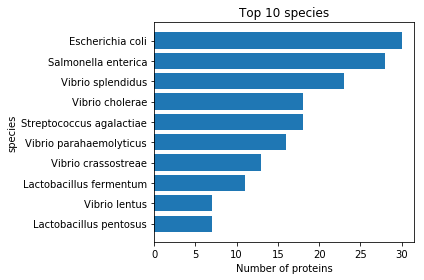

In [30]:
graph_most_abondant_rank(data_overlap_domains,"species",10,"/Users/chilpert/Results/NOX_visu_clean/NOX_top10_species.pdf")

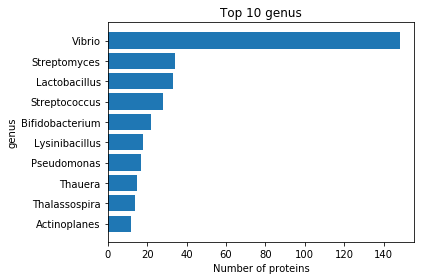

In [31]:
graph_most_abondant_rank(data_overlap_domains,"genus",10,"/Users/chilpert/Results/NOX_visu_clean/NOX_top10_genus.pdf")

### Regroup co-occurent domains

In [66]:
from igraph import plot 

In [67]:
graph=data_overlap_domains.create_domain_graph(core_domains)

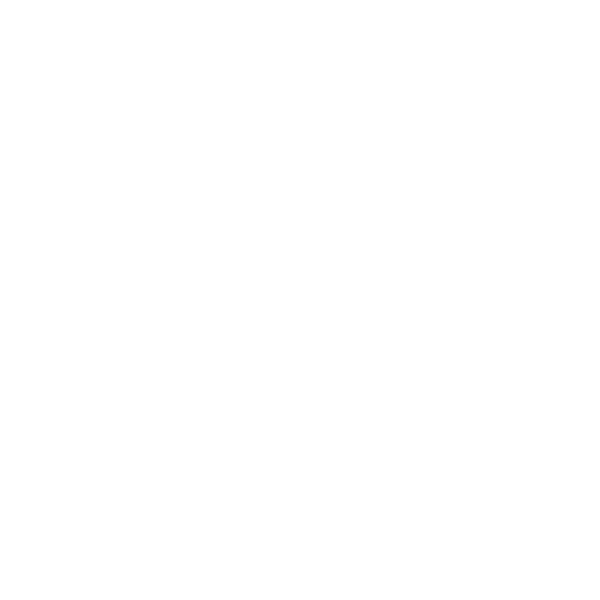

In [68]:
plot(graph,vertex_label_dist=1.5,vertex_label_size=12,edge_label_dist=0,edge_color="grey",target="/Users/chilpert/Results/NOX_visu_clean/NOX_graph_domains.pdf",margin=50)    

In [69]:
from statistics import mean
def plot_connected_comp(g):
    connected_comp=g.clusters()
    nb_cc=0
    global_output="/Users/chilpert/Results/NOX_domain_components.tsv"
    go=open(global_output,"w")
    go.write("#Component\tDomains\tMean_weight\n")
    for cc in connected_comp.subgraphs(): 
        if len(cc.vs["name"])>1: 
            nb_cc+=1
            list_percent=[]
            print("== COMP",nb_cc)
            plot(cc,vertex_label_dist=1.5,vertex_label_size=25,edge_label_dist=0,edge_color="grey",target="/Users/chilpert/Results/NOX_visu_clean/NOX_comp"+str(nb_cc)+".pdf",margin=100,edge_label_size=20)
            mean_weight=mean(cc.es["weight"])
            go.write(str(nb_cc)+"\t"+",".join(cc.vs["name"])+"\t"+str(mean_weight)+"\n")
    go.close()      

In [70]:
plot_connected_comp(graph)